In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import json

df = pd.read_csv('../CLEANED_WA_Fn-UseC_-Telco-Customer-Churn.csv')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna(subset=['TotalCharges'])


In [17]:

target = 'Churn'
all_features = [
    'gender','SeniorCitizen','Partner','Dependents','tenure','PhoneService',
    'MultipleLines','InternetService','OnlineSecurity','OnlineBackup',
    'DeviceProtection','TechSupport','StreamingTV','StreamingMovies',
    'Contract','PaperlessBilling','PaymentMethod','MonthlyCharges','TotalCharges'
]
reduced_features = [f for f in all_features if f not in ['TotalCharges','gender','PhoneService']]


In [18]:

X = df[all_features]
y = df[target].map({'Yes': 1, 'No': 0})
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train_red = X_train_full[reduced_features]
X_test_red = X_test_full[reduced_features]


In [ ]:
# 4. Preprocessing 
# Ordinal encoding for 'Contract'
ordinal_enc = OrdinalEncoder(categories=[['Month-to-month', 'One year', 'Two year']])

cat_full = [col for col in all_features if df[col].dtype == 'object' and col != 'Contract']
num_full = ['tenure', 'MonthlyCharges', 'TotalCharges']

cat_red = [col for col in reduced_features if df[col].dtype == 'object' and col != 'Contract']
num_red = ['tenure', 'MonthlyCharges']


In [ ]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer


preprocessor_full = ColumnTransformer([
    ("ord_contract", OrdinalEncoder(categories=[['Month-to-month','One year','Two year']]),["Contract"]),
    ("onehot", OneHotEncoder(drop="first", sparse_output=False), cat_full),
    ("scale", StandardScaler(), num_full),
])

preprocessor_red = ColumnTransformer([
    ("ord_contract", OrdinalEncoder(categories=[['Month-to-month','One year','Two year']]), ["Contract"]),
    ("onehot", OneHotEncoder(drop="first", sparse_output=False), cat_red),
    ("scale",   StandardScaler(), num_red),
])


In [22]:

pipe_full = Pipeline([
    ('pre', preprocessor_full),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
])

pipe_red = Pipeline([
    ('pre', preprocessor_red),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
])


In [23]:

pipe_full.fit(X_train_full, y_train)
pipe_red.fit(X_train_red, y_train)


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('ord_contract',
                                                  OrdinalEncoder(categories=[['Month-to-month',
                                                                              'One '
                                                                              'year',
                                                                              'Two '
                                                                              'year']]),
                                                  ['Contract']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['Partner', 'Dependents',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('scale', StandardScaler(),
                                                  ['tenure',
                                                   'MonthlyCharges'])])),
                ('rf', RandomForestClassifier(random_state=42))])

In [24]:

# 7. Evaluate
results = {}
for name, pipe, X_test in [
    ('full', pipe_full, X_test_full),
    ('reduced', pipe_red, X_test_red)
]:
    y_pred = pipe.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred).tolist()
    results[name] = {'classification_report': report, 'confusion_matrix': cm}

    print(f"\n=== {name.upper()} MODEL ===")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(cm)



=== FULL MODEL ===
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.49      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.77      0.79      0.78      1407

Confusion Matrix:
[[923, 110], [192, 182]]

=== REDUCED MODEL ===
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1033
           1       0.60      0.50      0.55       374

    accuracy                           0.78      1407
   macro avg       0.72      0.69      0.70      1407
weighted avg       0.77      0.78      0.77      1407

Confusion Matrix:
[[910, 123], [187, 187]]


In [25]:

# 8. Save artifacts
joblib.dump(pipe_full, 'rf_telco_full_pipeline.pkl')
joblib.dump(pipe_red, 'rf_telco_reduced_pipeline.pkl')

joblib.dump((X_train_full, X_test_full, y_train, y_test), 'telco_train_test_full.pkl')
joblib.dump((X_train_red, X_test_red), 'telco_train_test_reduced.pkl')

with open('telco_rf_results.json', 'w') as f:
    json.dump(results, f)

print("\nModels, data splits, and evaluation results saved successfully.")



Models, data splits, and evaluation results saved successfully.


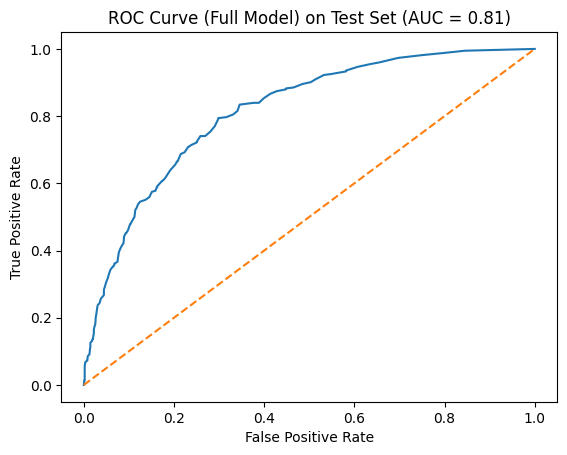

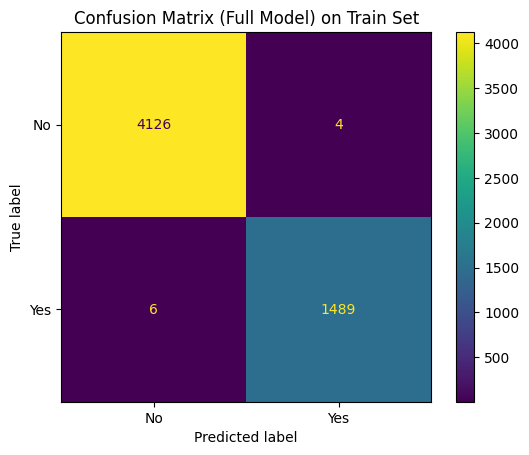

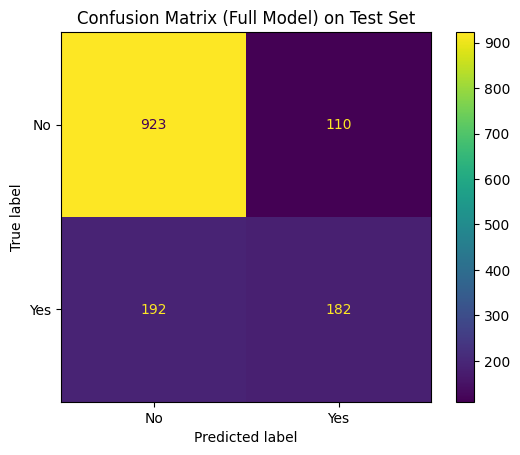

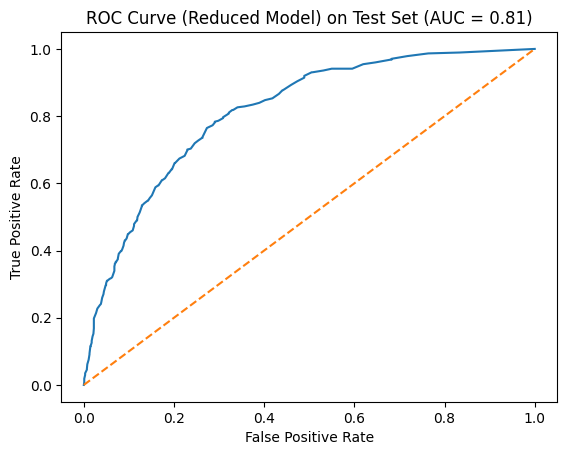

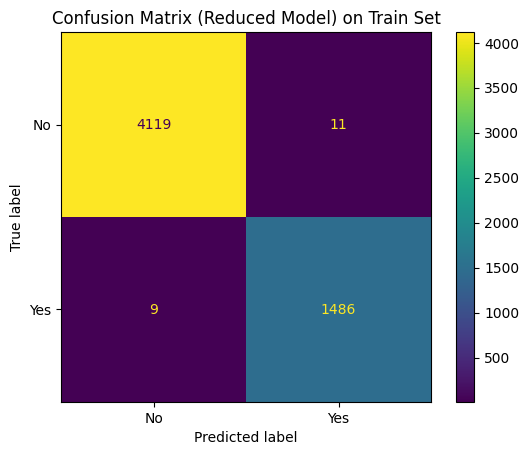

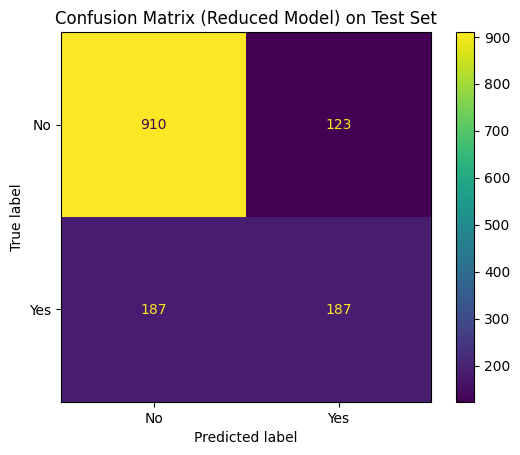

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay

# List of models and corresponding datasets
models = [
    ('Full Model', pipe_full, X_train_full, X_test_full),
    ('Reduced Model', pipe_red, X_train_red, X_test_red),
]

for name, pipe, X_tr, X_te in models:
    # ROC Curve on Test Set
    y_proba = pipe.predict_proba(X_te)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title(f'ROC Curve ({name}) on Test Set (AUC = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

    # Confusion Matrices for Train and Test
    for split_name, X_split, y_split in [('Train', X_tr, y_train), ('Test', X_te, y_test)]:
        disp = ConfusionMatrixDisplay.from_predictions(
            y_split,
            pipe.predict(X_split),
            display_labels=['No', 'Yes']
        )
        plt.title(f'Confusion Matrix ({name}) on {split_name} Set')
        plt.show()
